# Лабораторная работа №6: Исследование результатов фильтрации дискретного сигнала с помощью рекурсивных фильтров, построенных на основе формул численного дифференцирования и интегрирования

Выполнили студенты гр. 1384 Камынин Александр Александрович и Кондратенко Константин Евгеньевич. Вариант №8.

## Цель работы

Получение практических навыков выполнения фильтрации дискретных последовательностей с помощью фильтров, построенных на основе формул численного дифференцирования и интегрирования



## Основные теоретические положения


**Дискретное преобразование Фурье (ДПФ)**:
Дискретное преобразование Фурье преобразует временные отсчеты в частотные компоненты, позволяя увидеть, какие частоты присутствуют в сигнале.

$ X(n) = \sum_{k=0}^{N-1} x_k e^{-i \frac{2\pi}{N} kn} $

где: $ X(n) $ — значение ДПФ на $ n $-й частоте, $ x_k $ — временной сигнал, $ N $ — общее количество отсчетов в сигнале, $ k $ — индекс частоты, который принимает значения от 0 до $ N-1 $.


**Линейное сглаживание по 5ти точкам**: $ H(\omega) = \frac{1}{5} (s_{n - 2} + s_{n - 1} + s_n + s_{n + 1} + s_{n + 2}) $

**Линейное сглаживание по 9ти точкам**: $ H(\omega) = \frac{1}{9} (s_{n-4} + s_{n-3} + s_{n - 2} + s_{n - 1} + s_n + s_{n + 1} + s_{n + 2} + s_{n+3} + s_{n+4}) $, где $ s_n = e^{i \omega n} $

**Формулы для численного дифференцирования:**: 
- Дифференцирование первого порядка: $$ y(n+1) = \frac{ (x_{n+1} - x_{n-1}) }{2h}  $$

**Квадратурные формулы для численного интегрирования:**
- Формула прямоугольников: $$y_{n+1} = y_n + s_{n+\frac{1}{2}}$$
- Формула трапеций: $$y_{n+1} = y_n + \frac{1}{2}(s_n + s_{n+1})$$
- Формула Симпсона: $$y_{n+1} = y_{n-1} + \frac{1}{3}(s_{n-1} + 4s_n + s_{n+1})$$

## Постановка задачи

Для заданного дискретного сигнала применить фильтры, основанные на формулах численного дифференцирования и интегрирования. Полученные результаты содержательно проинтерпретировать. 

## Выполнение работы

In [57]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import scipy

from IPython.display import display, Math

# для воспроизводимости результатов
RANDOM_SEED = 42

In [58]:
np.random.seed(RANDOM_SEED)

### Задание 1.

Сформировать дискретный сигнал посредством дискретизации с шагом T=1 непрерывного сигнала, представляющего собой линейную комбинацию косинусоид вида $A_k \cos(\omega_k t + \phi_k)$. Частота каждой из гармоник не должна превышать π. Всего одиннадцать гармоник с упорядоченными по возрастанию частотами от 0 до π, изменяющимися с шагом Δω=0.1π. Амплитуды гармоник Ak представляют собой целые числа со значениями от 1 до 11, определяемые случайным образом с помощью датчика равномерно распределенных случайных чисел. При необходимости нормализовать коэффициенты линейной комбинации посредством деления их на сумму полученных случайным образом амплитуд. Начальные фазы $\phi_k$ представляют собой случайные числа в промежутке от 0 до 0.5. Дискретная последовательность должна включать в себя 32 отсчета (N=31).

Непрерывный сигнал $ x_{\text{analog}} $ был получен в соответствии со случайной генерацией амплитуды, частоты и начальной фазы в заданных пределах на промежутке [0, 32].

Для дискретного сигнала была проведена такая же генерация с шагом $T = 1$, всего последовательность включает 32 отсчета.

Формула для полученного дискретного сигнала имеет вид: $ x_{\text{discrete}}(n) = \sum_{k=1}^{11} A_k \cdot \cos(w_k \cdot n + \phi_k) $

Амплитуды гармоник нормализованы посредством деления их на сумму полученных случайным образом амплитуд: $ A'_k = \frac{A_k}{\sum_{i=1}^{11} A_i} $

In [59]:
import numpy as np
import matplotlib.pyplot as plt

omega_k = np.linspace(0, np.pi, 11)
A_k = np.random.randint(1, 12, size=11)
phi_k = np.random.uniform(0, 0.5, size=11)
A_k_normalized = A_k / np.sum(A_k)


def get_signal(N=1):
    t = np.linspace(0, 32, N)
    x_t = np.zeros_like(t, dtype=float)

    for k in range(11):
        x_t += A_k_normalized[k] * np.cos(omega_k[k] * t + phi_k[k])
        
    return t, x_t

t_discrete, x_discrete = get_signal(N=32)
t_analog, x_analog = get_signal(N=10000)

### Задание 2.

Визуализировать исходные аналоговый и дискретизированный сигналы.

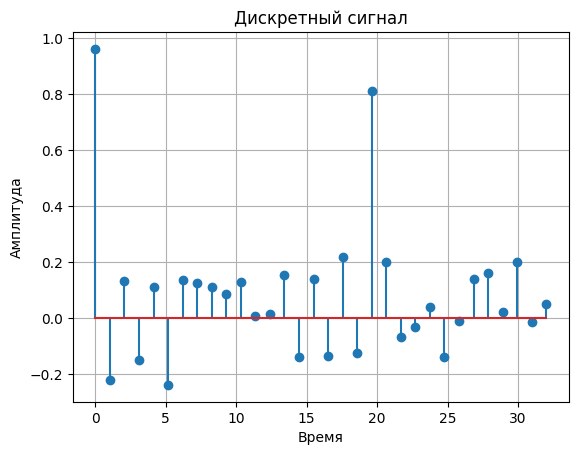

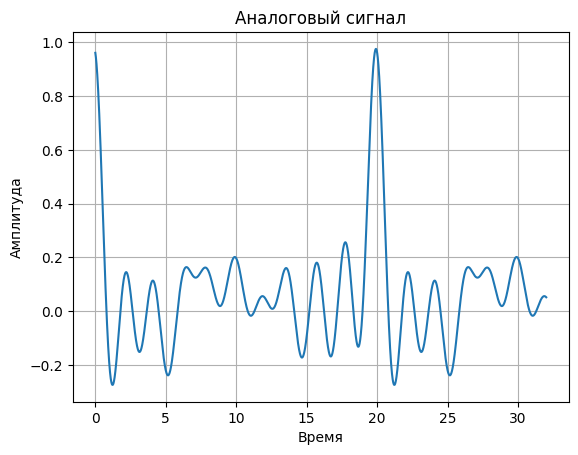

In [60]:
plt.stem(t_discrete, x_discrete)
plt.title('Дискретный сигнал')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.show()

plt.plot(t_analog, x_analog)
plt.title('Аналоговый сигнал')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.show()

### Задание 3.

С помощью ДПФ найти дискретные отсчеты спектра дискретного сигнала и визуализировать их.

Перепишем дискретный сигнал в виде суммы сдвигов дельта-функции:

$$ s_{\text{discrete}} (t) = \sum_{k=-\infty}^{+\infty} s(t) \delta(t - kT) $$

Знаем, что сигнал дискретный гармонический, поэтому можно переписать его в виде ряда Фурье:

$$ \sum_{k=-\infty}^{+\infty} \delta(t - kT) = \sum_{k=-\infty}^{+\infty} c_k \cdot e^{i \omega_k t} $$ 

где $ \omega_k = \frac{2 \pi k}{T} $, $ c_k = \frac{1}{T} \int_{-\frac{T}{2}}^{\frac{T}{2}} \delta(t) e^{-i \omega_k t} dt = \frac{1}{T} $

Итого, дискретный сигнал принимает вид:

$$ s_{\text{discrete}} (t) = \frac{1}{T} \sum_{k=-\infty}^{+\infty} s(t) e^{i \omega_k t} $$

Спектр сигнала имеет вид:

$$ S_{\text{discrete}}(\omega) = \frac{1}{T} \sum_{k=-\infty}^{+\infty} S(\omega - \frac{2 \pi k}{T}) $$

Для получения спектра с помощью ДПФ будем пользоваться готовыми реализациями из библиотеки SciPy:
- ДПФ (БПФ, FFT): https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html#scipy.fftpack.fft
- Получение частот спектра: https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fftfreq.html


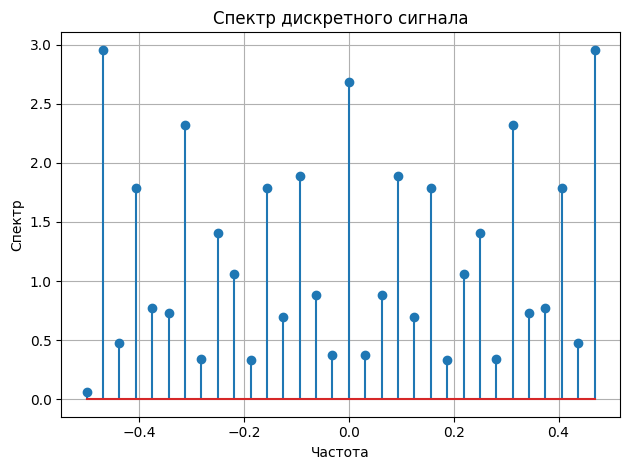

In [61]:
from scipy.fftpack import fft, fftfreq

def compute_dft(x):
    X_fft = fft(x)
    frequencies = fftfreq(d=1, n=32)
    return frequencies, X_fft

freq, x_fft = compute_dft(x_discrete)
spectrum = np.abs(x_fft)

plt.stem(freq, spectrum)
plt.title('Спектр дискретного сигнала')
plt.xlabel('Частота')
plt.ylabel('Спектр')
plt.grid(True)
plt.tight_layout()
plt.show()

### Задача 4.

Для дискретного сигнала применить линейное сглаживание по 5-ти и 9-ти точкам, представить формулу для H(ω) – передаточной функции (частотной характеристики) фильтра.

Формулы для линейного сглаживания по 5ти и 9ти точкам (в формулах $ s_n = e^{i \omega n} $):

По 5ти: $ H(\omega) = \frac{1}{5} (s_{n - 2} + s_{n - 1} + s_n + s_{n + 1} + s_{n + 2}) $

По 9ти: $ H(\omega) = \frac{1}{9} (s_{n-4} + s_{n-3} + s_{n - 2} + s_{n - 1} + s_n + s_{n + 1} + s_{n + 2} + s_{n+3} + s_{n+4}) $

Применение фильтра, соответствующего линейному сглаживанию, соответствует операции свертки исходного сигнала с фильтром, определенным оконной функцией. В данном случае окна - веса каждого сигнала, они равны 1/5 и 1/9 соответственно.

Для применения фильтра воспользуемся готовой реализацией в Numpy:
- https://numpy.org/doc/stable/reference/generated/numpy.convolve.html


In [62]:
lin_5 = np.convolve(x_discrete, np.ones(5) / 5, mode='same')
lin_9 = np.convolve(x_discrete, np.ones(9) / 9, mode='same')

### Задача 5.

Визуализировать полученный после фильтрации дискретный сигнал совместно с исходным дискретным сигналом.

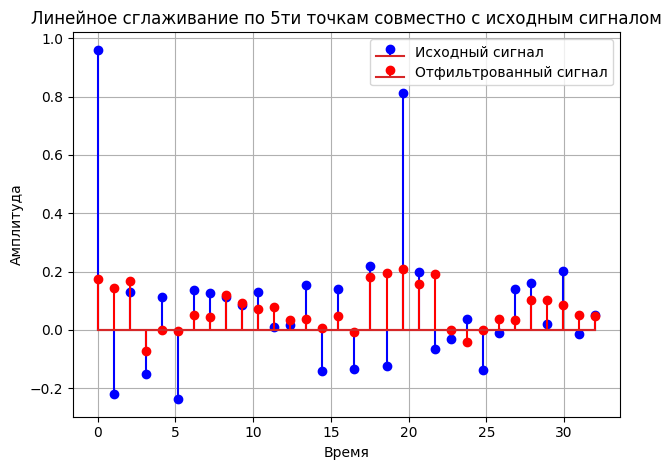

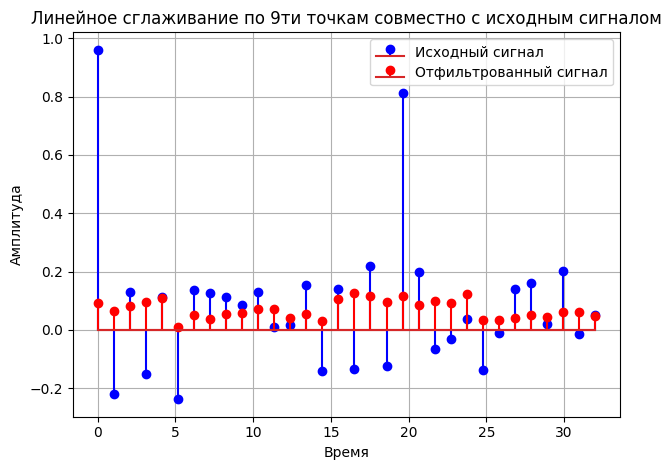

In [63]:
plt.stem(t_discrete, x_discrete, 'b', label='Исходный сигнал')
plt.stem(t_discrete, lin_5, 'r-', label="Отфильтрованный сигнал")
plt.title('Линейное сглаживание по 5ти точкам совместно с исходным сигналом')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.stem(t_discrete, x_discrete, 'b', label='Исходный сигнал')
plt.stem(t_discrete, lin_9, 'r-', label="Отфильтрованный сигнал")
plt.title('Линейное сглаживание по 9ти точкам совместно с исходным сигналом')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Задача 6.

С помощью ДПФ найти дискретные отсчеты спектра дискретного сигнала после его фильтрации и визуализировать их совместно с отчетами спектра исходного дискретного сигнала.

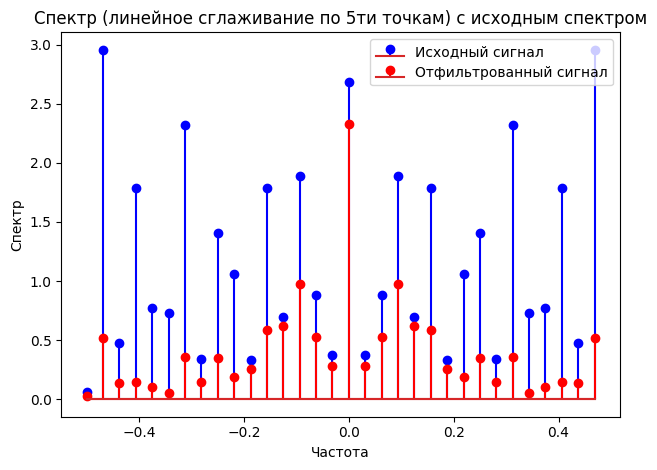

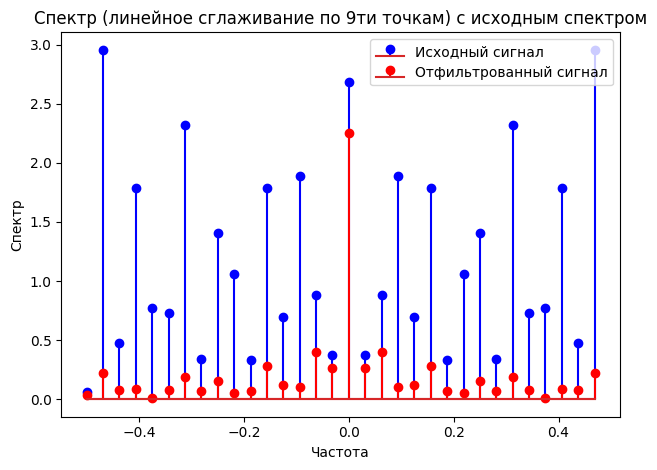

In [64]:
freq, x_filtered5_fft = compute_dft(lin_5)
lin5_spectrum = np.abs(x_filtered5_fft)

plt.stem(freq, spectrum, 'b', label="Исходный сигнал")
plt.stem(freq, lin5_spectrum, 'r-', label='Отфильтрованный сигнал')
plt.ylabel('Спектр')
plt.xlabel('Частота')
plt.title('Спектр (линейное сглаживание по 5ти точкам) c исходным спектром')
plt.legend()
plt.tight_layout()
plt.show()


freq, x_filtered9_fft = compute_dft(lin_9)
lin9_spectrum = np.abs(x_filtered9_fft)

plt.stem(freq, spectrum, 'b', label="Исходный сигнал")
plt.stem(freq, lin9_spectrum, 'r-', label='Отфильтрованный сигнал')
plt.ylabel('Спектр')
plt.xlabel('Частота')
plt.title('Спектр (линейное сглаживание по 9ти точкам) с исходным спектром')
plt.legend()
plt.tight_layout()
plt.show()

### Задача 7.

Проанализировать результат на соответствие значениям H(ω). Сделать выводы.

По построенным графикам можно сделать следующие выводы:
1. При использовании сглаживания на **пяти** точкам амплитуды высокочастотных компонент усредняются, что делает результирующий сигнал более однородным по частотам. Фильтр сглаживает получаемый сигнал, приводя его вид к средним значениям.
2. При использовании сглаживания на **девяти** точкам амплитуды высокочастотных компонент усредняются сильнее, чем в случае сглаживания по пяти точкам. Фильтр сглаживает получаемый сигнал, приводя его вид к средним значениям, но из-за того, что одновременно рассматриваются 9 точек, то и усреднение более выраженное.

### Задача 8.

Повторить п. 4–7 для следующих фильтров:
- Дискретный фильтр, соответствующий численному дифференцированию 1-го порядка.
- Дискретный фильтр, соответствующий численному интегрированию (прямоугольников, трапеций, Симпсона).

In [65]:
def s(k):
    sk = 0
    for i in range(11):
        sk += A_k_normalized[i] * np.cos(omega_k[i] * k + phi_k[i])
    return sk

def numeral_diff(x):
    output = np.zeros_like(x)
    output[0] = x[0] / 2
    output[-1] = x[-1] / 2
    for i in range(1, len(output) - 1):
        output[i] = (x[i+1] - x[i-1]) / 2*1
        
    return output

def rectangle(x):
    output = np.zeros_like(x)
    for i in range(0, len(output) - 1):
        output[i+1] = output[i] + s(i + 1/2)
    return output

def trapez(x):
    output = np.zeros_like(x)
    for i in range(0, len(output) - 1):
        output[i+1] = output[i] + (s(i) + s(i+1)) / 2
    return output

def simpson(x):
    output = np.zeros_like(x)
    for i in range(0, len(output) - 1):
        output[i+1] = output[i-1] + (s(i-1) + 4*s(i) + s(i+1)) / 3
    return output

num_diff = numeral_diff(x_discrete)
rect_filter = rectangle(x_discrete)
trapez_filter = trapez(x_discrete)
simpson_filter = simpson(x_discrete)

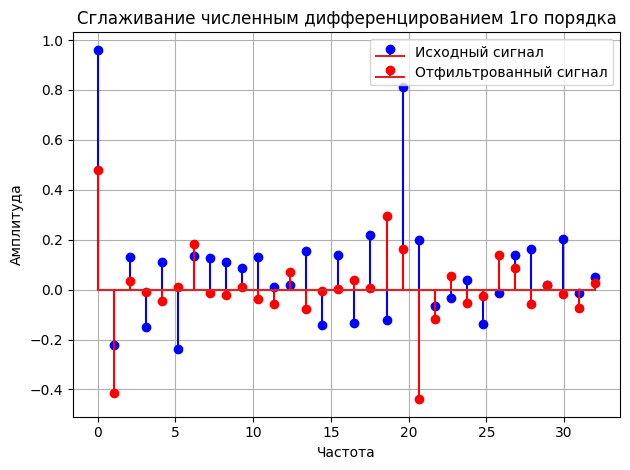

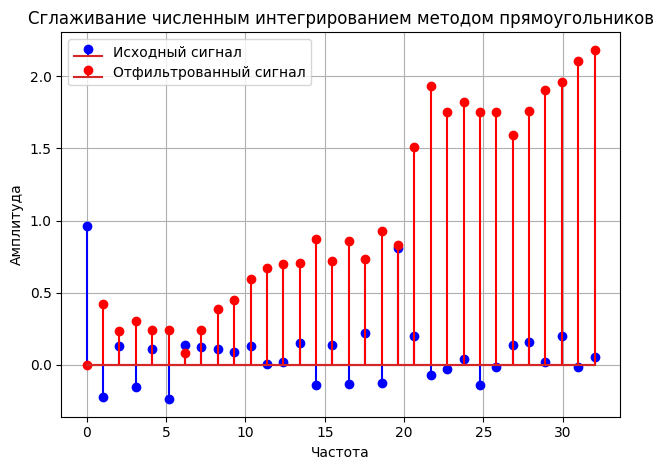

In [66]:
plt.stem(t_discrete, x_discrete, 'b', label='Исходный сигнал')
plt.stem(t_discrete, num_diff, 'r-', label="Отфильтрованный сигнал")
plt.title('Сглаживание численным дифференцированием 1го порядка')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.stem(t_discrete, x_discrete, 'b', label='Исходный сигнал')
plt.stem(t_discrete, rect_filter, 'r-', label="Отфильтрованный сигнал")
plt.title('Сглаживание численным интегрированием методом прямоугольников')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

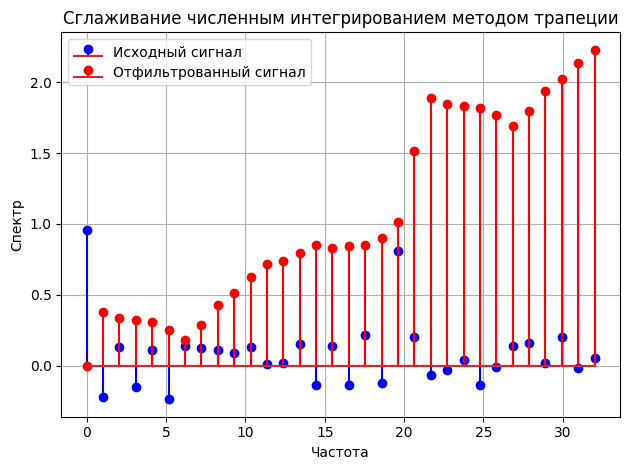

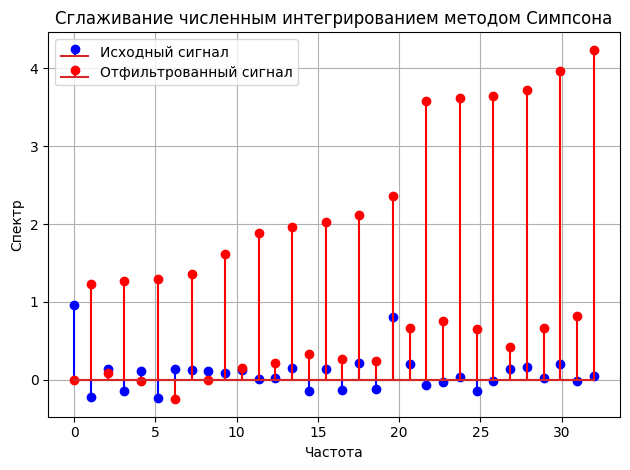

In [67]:
plt.stem(t_discrete, x_discrete, 'b', label='Исходный сигнал')
plt.stem(t_discrete, trapez_filter, 'r-', label="Отфильтрованный сигнал")
plt.title('Сглаживание численным интегрированием методом трапеции')
plt.xlabel('Частота')
plt.ylabel('Спектр')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.stem(t_discrete, x_discrete, 'b', label='Исходный сигнал')
plt.stem(t_discrete, simpson_filter, 'r-', label="Отфильтрованный сигнал")
plt.title('Сглаживание численным интегрированием методом Симпсона')
plt.xlabel('Частота')
plt.ylabel('Спектр')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

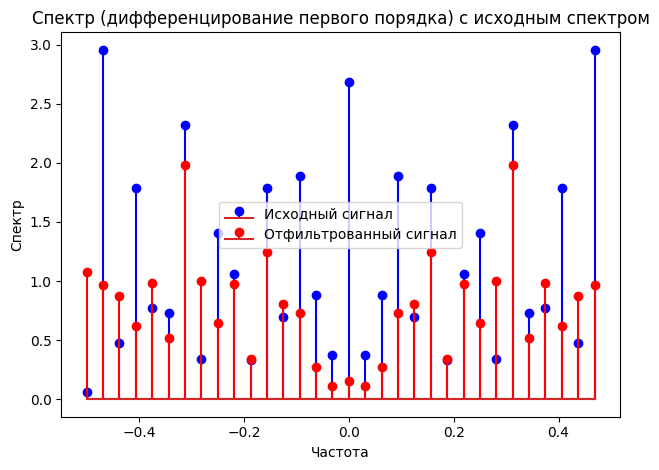

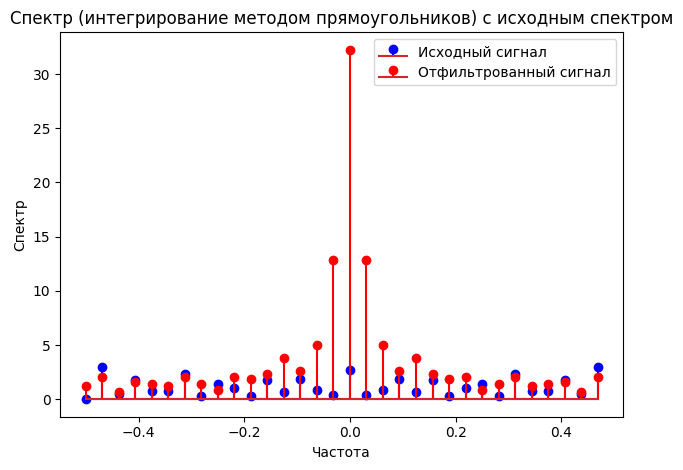

In [68]:
freq, num_diff_spectrum = compute_dft(num_diff)
num_diff_spectrum = np.abs(num_diff_spectrum)

plt.stem(freq, spectrum, 'b', label='Исходный сигнал')
plt.stem(freq, num_diff_spectrum, 'r-', label="Отфильтрованный сигнал")
plt.ylabel('Спектр')
plt.xlabel('Частота')
plt.title('Спектр (дифференцирование первого порядка) с исходным спектром')
plt.legend()
plt.tight_layout()
plt.show()


freq, rect_filter_spectrum = compute_dft(rect_filter)
rect_filter_spectrum = np.abs(rect_filter_spectrum)

plt.stem(freq, spectrum, 'b', label='Исходный сигнал')
plt.stem(freq, rect_filter_spectrum, 'r-', label="Отфильтрованный сигнал")
plt.ylabel('Спектр')
plt.xlabel('Частота')
plt.title('Спектр (интегрирование методом прямоугольников) с исходным спектром')
plt.legend()
plt.tight_layout()
plt.show()

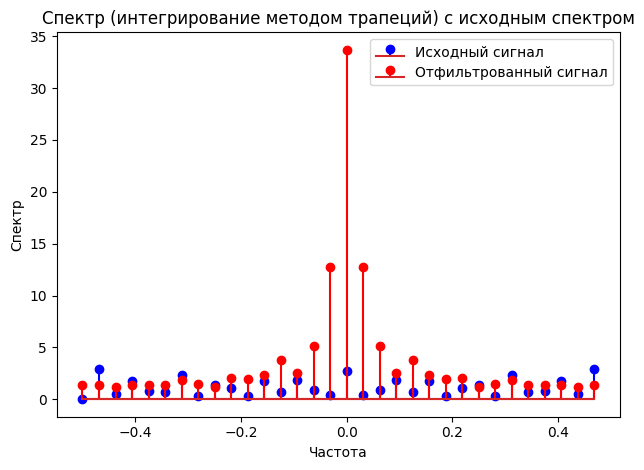

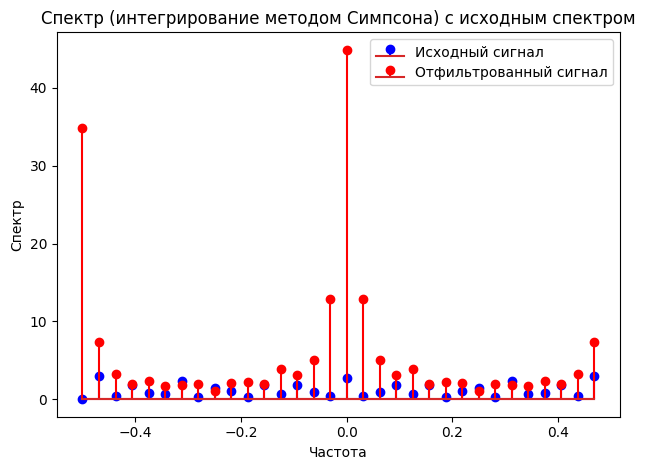

In [69]:
freq, trapez_filter_spectrum = compute_dft(trapez_filter)
trapez_filter_spectrum = np.abs(trapez_filter_spectrum)

plt.stem(freq, spectrum, 'b', label='Исходный сигнал')
plt.stem(freq, trapez_filter_spectrum, 'r-', label="Отфильтрованный сигнал")
plt.ylabel('Спектр')
plt.xlabel('Частота')
plt.title('Спектр (интегрирование методом трапеций) с исходным спектром')
plt.legend()
plt.tight_layout()
plt.show()


freq, simpson_filter_spectrum = compute_dft(simpson_filter)
simpson_filter_spectrum = np.abs(simpson_filter_spectrum)

plt.stem(freq, spectrum, 'b', label='Исходный сигнал')
plt.stem(freq, simpson_filter_spectrum, 'r-', label="Отфильтрованный сигнал")
plt.ylabel('Спектр')
plt.xlabel('Частота')
plt.title('Спектр (интегрирование методом Симпсона) с исходным спектром')
plt.legend()
plt.tight_layout()
plt.show()

### Задача 9.

Содержательно проинтерпретировать результаты выполнения практической работы, сделать выводы.

По результатам, полученным в ходе выполнения работы можно сделать следующие выводы:
1. Дискретный сигнал с выбранной частотой дискретизации представляет собой "упрощенную" модель исходного сигнала. Фильтры, применяемые к дискретному сигналу, все, кроме численного дифференцирования, усилили сигнал, так, как сигнал на большей своей части больше нуля. 
2. Дискретный сигнал с выбранной частотой дискретизации при применения фильтра, основнанного на численном дифференцировании, по модулю ослабляет сигнал
3. По графика совмещения спектров отчетливо видно, как все фильтры, кроме численного дифференцирования, усилили сигнал, при этом наибольшое уселение наблюдается в окрестности нуля. 
4. Наибольшие уселение сигналов наблюдается в области высокой частоты.

## Выводы


В ходе выполнения лабораторной работы, сформирован аналоговый и на его основе дискретный сигнал, к которому применены следующие дискретные фильтры:
1. Линейное сглаживание по 5 и 9 точкам
2. Фильтр основанный на численном дифференцировании 1-го порядка
3. Фильтр основанный на численном интегрировании (прямоугольников, трапеций, Симпсона).

Дискретный и аналоговый сигналы визуализированы средствами Python. В целях изучения поведения дискретных рекурсивных фильтров визуализированы значения сигнала до фильтрации и после, благодаря чему оценено влияние фильтра на входной сигнал. Также силами Python с помощью дискретного преобразования Фурье найдены отсчеты спектра для исходного дискретного сигнала и для результатов его фильтрации дискретными нерекурсивными фильтрами, перечисленными выше.